# PSORIASIS DETECTION USING MACHINE LEARNING

The project's aim is to enhance the early detection and classification of psoriasis through the application of machine learning methodologies. The significance of early diagnosis in psoriasis management and its impact on patient well-being is underscored, necessitating a shift from traditional diagnostic methods towards automated machine learning systems. The primary goal of this research is to create an accessible and effective tool for the early detection of psoriasis by utilizing a variety of machine learning models. These models, including CNN, Bi-LSTM, Bi-GRU, ResNet50, DenseNet121, MobileNetV2, InceptionV3, Xception, and NASNet, are trained on carefully preprocessed datasets. Evaluation metrics and callback mechanisms are employed to assess the models' performance rigorously. To enable practical implementation, the models are deployed as HTTP services on Google Cloud, allowing users to submit images for psoriasis classification. Furthermore, a mobile application is developed using React Native, providing users with a user-friendly tool for psoriasis detection.

# Configure Hardware

I start by configuring TensorFlow for deep learning tasks by suppressing most warning messages, setting the logging level to 'ERROR' for error reporting, checking available physical GPUs on the system, enabling dynamic GPU memory allocation, and finally printing the list of detected GPUs. These adjustments aim to create a cleaner and more efficient environment for TensorFlow operations on GPU hardware.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Disable warinings

import tensorflow
tensorflow.get_logger().setLevel('ERROR')

gpu = tensorflow.config.experimental.list_physical_devices('GPU')
tensorflow.config.experimental.set_memory_growth(gpu[0], True)
print(gpu)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


The following code utilizes the `psutil` library to monitor system performance. This code offers a basic system performance monitoring tool to track available RAM and CPU usage.

In [2]:
import psutil

# Convert to gigabytes for a more human-readable output
available_memory_gb = psutil.virtual_memory().available / (1024 ** 3)
print(f"Available RAM: {available_memory_gb:.2f} GB")

cpu_usage = psutil.cpu_percent(interval=1)  # You can adjust the interval as needed
print(f"CPU Usage: {cpu_usage:.2f}%")

Available RAM: 6.91 GB
CPU Usage: 2.70%


# Distribution of Classes
viewing the distribution of classes is a critical step in the data preprocessing and model development pipeline. It helps you make informed decisions about how to handle imbalances, choose appropriate evaluation metrics, and ensure the fairness and effectiveness of your deep learning models.

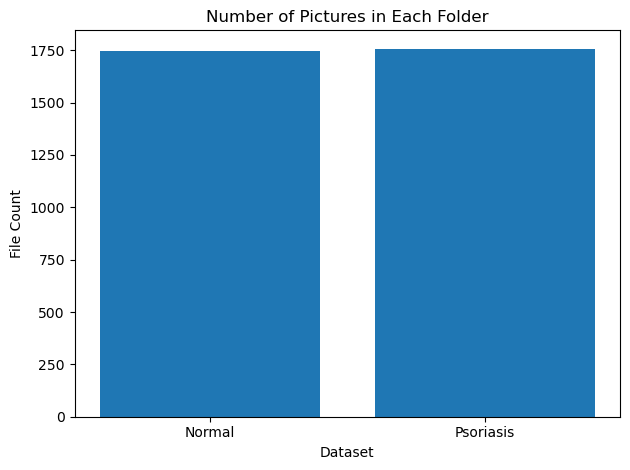

In [3]:
import matplotlib.pyplot

def num_files(folder_path):
    folder_contents = os.listdir(folder_path)
    file_count = 0

    for item in folder_contents:
        item_path = os.path.join(folder_path, item)
        if os.path.isfile(item_path):
            file_count += 1

    return file_count

def plot_file_counts(normal_folder, psoriasis_folder):
    normal_count = num_files(normal_folder)
    psoriasis_count = num_files(psoriasis_folder)
    
    folders = ['Normal', 'Psoriasis']
    file_counts = [normal_count, psoriasis_count]
    
    matplotlib.pyplot.bar(folders, file_counts)
    matplotlib.pyplot.xlabel('Dataset')
    matplotlib.pyplot.ylabel('File Count')
    matplotlib.pyplot.title('Number of Pictures in Each Folder')
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

plot_file_counts('dataset/normal', 'dataset/psoriasis')

# Load Dataset

A function from the TensorFlow library is used to create an image dataset. The `image_dataset_from_directory` function takes a directory path as input and generates a dataset(tensorflow.data.Dataset) of images.

The images are resized to 256x256 pixels. The batch_size parameter is set to 16, meaning that the dataset will be divided into batches of 16 images each for processing.The color_mode is set to ‘rgb’, indicating that the images in the dataset will be in color (red, green, blue channels). 

This function makes it easy to load and preprocess images from a directory for use in a machine learning model.

## Main reasons for choosing to use a tensorflow.data.Dataset: 
- <b>EFFICIENCY</b>: The tf.data.Dataset API is designed to handle large amounts of data and can efficiently load and preprocess it. It can read from a variety of formats, so you do not have to convert the data to a specific format before using it.

- <b>FLEXIBILITY</b>: The API provides many built-in functions for common data operations, such as shuffling, batching, and repeating datasets. It also allows for custom preprocessing functions.

- <b>PERFORMANCE</b>: The tf.data.Dataset API uses a streaming architecture, which means it doesn’t need to load the entire dataset into memory at once. This makes it particularly useful for working with large datasets that don’t fit into memory.

In [49]:
data = tensorflow.keras.utils.image_dataset_from_directory('dataset',image_size=(256, 256),batch_size=16,color_mode='rgb')

Found 3493 files belonging to 2 classes.


# Visualize Dataset

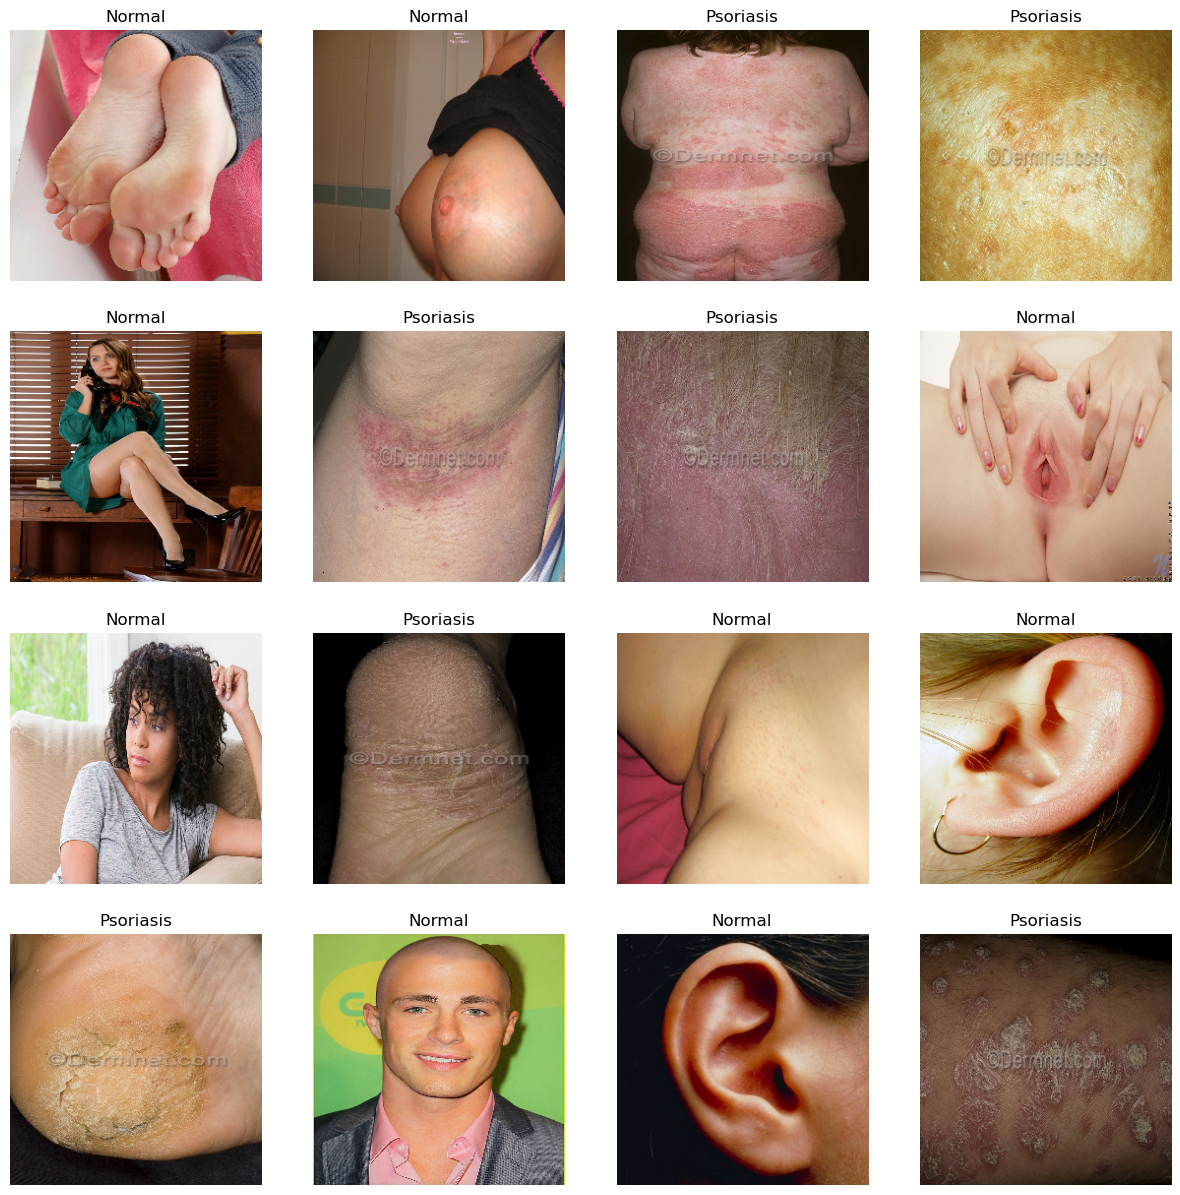

In [58]:
def plot_dataset(dataset,type, take=3):
    matplotlib.pyplot.figure(figsize=(15, 15))
    class_names =['Normal','Psoriasis']
    for images, labels in dataset.take(take):
        for i in range(16):
            ax = matplotlib.pyplot.subplot(4, 4, i + 1)
            matplotlib.pyplot.imshow(images[i].numpy().astype(type))
            matplotlib.pyplot.title(class_names[labels[i]])
            matplotlib.pyplot.axis("off")
            
def plot_batch(batch,type):
    fig, ax = matplotlib.pyplot.subplots(ncols=4, figsize=(20,20))
    for idx, img in enumerate(batch[0][:4]):
        ax[idx].imshow(img.astype(type))
        ax[idx].title.set_text(batch[1][idx])

data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

plot_dataset(data,"uint8")

# Scale Data

The lambda function inside `map` scales the pixel values of the images from [0, 255] to [0, 1] by dividing each pixel by 255. This normalization step is important because models often perform better on smaller input values.

In [6]:
data = data.map(lambda x,y: (x/255, y))

# Split Dataset

In [7]:
def split_dataset(data,train_size,val_size) :
    
    train_size = int(len(data)*train_size)
    val_size = int(len(data)*val_size)
    
    train_ds = data.take(train_size)
    val_ds = data.skip(train_size).take(val_size)
    
    return (train_ds,val_ds)

# Augment Data
- https://keras.io/guides/preprocessing_layers/

Data augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data. 

The `tensorflow.keras.Sequential` model is a linear stack of layers that you can use to create a neural network and can be used to define a data augmentation pipeline with the following steps:

- `RandomFlip("horizontal_and_vertical")`: This layer flips the images randomly either horizontally, vertically or both. This helps the model generalize better to new data by providing a slightly different perspective of the learned features.

- `RandomRotation(0.1)`: This layer rotates the image by a random factor of ±10% (0.1). Again, this helps the model generalize better by providing it with different orientations of the learned features.

- `RandomContrast(0.1)`: This layer adjusts the contrast of the image by a random factor of ±10% (0.1). This can help the model generalize to images with varying lighting conditions.

In [8]:
def augment_dataset(data):
    
    data_augmentation = tensorflow.keras.Sequential([
                                                    tensorflow.keras.layers.RandomFlip("horizontal_and_vertical"),
                                                    tensorflow.keras.layers.RandomRotation(0.1),
                                                    tensorflow.keras.layers.RandomContrast(0.1)
                                                    ])
    
    data = data.map(lambda img, label: (data_augmentation(img), label), num_parallel_calls=tensorflow.data.AUTOTUNE,)
    
    return data

# Optimize for Performance

The `prefetch` transformation prepares the data for the next batch while the current batch is in use. This overlap of preprocessing and model execution is what makes the `prefetch` transformation very useful, as it improves the latency and throughput of the training steps in a deep learning pipeline.

The argument `tensorflow.data.AUTOTUNE` allows the `tf.data` runtime to tune the value dynamically at runtime, this means that it will try to find the optimal number of batches to prefetch based on the system conditions, hence improving the efficiency of data loading.

This aims to prevent which bottlenecks in training deep learning models.

In [9]:
def prefetch_data(data):
    
    preteched = data.prefetch(tensorflow.data.AUTOTUNE)
    
    return preteched

# Plot Functions

In [10]:
import plotly.graph_objs as go

def metric_train_vs_val(hist):
    fig = go.Figure()

    x = list(range(len(hist.history['loss'])))
    
    # Plot the second subplot (Accuracy)
    fig.add_trace(go.Scatter(x=x, y=hist.history['accuracy'], name='accuracy', line=dict(color='blue'),legendgroup='Accuracy'))
    fig.add_trace(go.Scatter(x=x, y=hist.history['val_accuracy'], name='val_accuracy', line=dict(color='orange'),legendgroup='Accuracy',showlegend=False))
    fig.update_layout(title='Accuracy', xaxis_title='Epochs', yaxis_title='Value')
    
    # Plot the first subplot (Loss)
    fig.add_trace(go.Scatter(x=x, y=hist.history['loss'], name='loss', line=dict(color='blue'),legendgroup='Loss'))
    fig.add_trace(go.Scatter(x=x, y=hist.history['val_loss'], name='val_loss', line=dict(color='orange'),legendgroup='Loss',showlegend=False))
    fig.update_layout(title='Loss', xaxis_title='Epochs', yaxis_title='Value')
    
    title = 'Training vs Validation Metrics'
    fig.update_layout(title=title,legend=dict(x=0, y=1.0))
    fig.update_xaxes(tickmode='array', tickvals=x)

    fig.update_layout(title_text='<b><span style="color:blue;">Training</span></b> vs <b><span style="color:orange;">Validation</span></b> Metrics')

    # Add dropdown
    fig.update_layout(
        updatemenus=[
            dict(
                type="buttons",
                direction="right",
                active=0,
                x=0.57,
                y=1.2,
                buttons=list([
                    dict(label="Both",
                         method="update",
                         args=[{"visible": [True, True, True, True]},
                               {"title.text": '<b><span style="color:blue;">Training</span></b> vs <b><span style="color:orange;">Validation</span></b> Metrics'}]),
                    dict(label="Accuracy",
                         method="update",
                         args=[{"visible": [True, True, False, False]},
                               {"title.text": '<b><span style="color:blue;">Training</span></b> vs <b><span style="color:orange;">Validation</span></b> Metrics'}]),
                    dict(label="Loss",
                         method="update",
                         args=[{"visible": [False, False, True, True]},
                               {"title.text": '<b><span style="color:blue;">Training</span></b> vs <b><span style="color:orange;">Validation</span></b> Metrics'}]),
                ]),
            )
        ])

    fig.show()


import plotly.graph_objects as go

def other_metrics(hist):
    fig = go.Figure()

    x = list(range(len(hist.history['loss'])))
    metrics = ['val_precision', 'val_recall', 'val_f1_score', 'val_auc', 'val_mcc', 'val_cohens_kappa']
    colors = ['teal', 'orange', 'red', 'blue', 'purple', 'green']

    for metric, color in zip(metrics, colors):
        fig.add_trace(go.Scatter(x=x, y=hist.history[metric], name=metric, line=dict(color=color)))

    # Add dropdown for selecting visible traces
    dropdown = [dict(label='All',
                     method='update',
                     args=[{'visible': [True]*len(metrics)},
                           {'title': 'All Metrics'}])]
    for i, metric in enumerate(metrics):
        visibility = [i==j for j in range(len(metrics))]
        dropdown.append(dict(label=metric,
                             method='update',
                             args=[{'visible': visibility},
                                   {'title': metric}]))

    fig.update_layout(
        updatemenus=[
            dict(type='dropdown',
                 showactive=True,
                 x=0.5,
                 y=1.2,
                 xanchor='center',
                 yanchor='top',
                 buttons=dropdown)
        ],
        title='All Metrics',
        xaxis_title='Epochs',
        yaxis_title='Value'
    )

    fig.show()
 
    
def compare_models(base_path):
    import pandas as pd
    
    folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
    all_data = pd.DataFrame()

    for folder in folders:
        
        file_path = os.path.join(base_path, folder, f'{folder}.txt') # specify the path to the text file
        with open(file_path, 'r') as f: data = {line.split(':')[0]: float(line.split(':')[1]) for line in f}

        # convert the dictionary into a pandas DataFrame and add it to all_data
        df = pd.DataFrame(data, index=[folder])
        all_data = pd.concat([all_data, df])

    fig = go.Figure()

    metrics = ['val_accuracy', 'val_auc', 'val_precision', 'val_recall', 'val_f1_score','val_cohens_kappa','val_mcc' ]
    for metric in metrics : fig.add_trace(go.Bar(x=all_data.index, y=all_data[metric], name=metric))

    fig.update_layout(title='Comparison of metrics across models', xaxis_title='Model', yaxis_title='Value',
                      updatemenus=[
                          dict(
                              type="buttons",
                              direction="right",
                              active=0,
                              x=0.57,
                              y=1.2,
                              buttons=list([
                                  dict(label="All",
                                       method="update",
                                       args=[{"visible": [True, True, True, True, True,False,False]},
                                             {"title": "All metrics"}]),
                                  dict(label="validation accuracy",
                                       method="update",
                                       args=[{"visible": [True, False, False, False, False,False,False]},
                                             {"title": "val_accuracy"}]),
                                  dict(label="auc",
                                       method="update",
                                       args=[{"visible": [False, True, False, False, False,False,False]},
                                             {"title": "auc"}]),
                                  dict(label="precision",
                                       method="update",
                                       args=[{"visible": [False, False, True, False, False,False,False]},
                                             {"title": "precision"}]),
                                  dict(label="recall",
                                       method="update",
                                       args=[{"visible": [False, False, False, True, False,False,False]},
                                             {"title": "recall"}]),
                                  dict(label="f1_score",
                                       method="update",
                                       args=[{"visible": [False, False, False, False, True,False,False]},
                                             {"title": "f1_score"}]),
                                  dict(label="cohens_kappa",
                                       method="update",
                                       args=[{"visible": [False, False, False, False, False,True,False]},
                                             {"title": "cohens_kappa"}]),
                                  dict(label="mcc",
                                       method="update",
                                       args=[{"visible": [False, False, False, False, False,False,True]},
                                             {"title": "mcc"}]),
                              ]),
                          )
                      ])

    fig.show()
    
import os
import pandas as pd
from IPython.display import display

# Increase the maximum number of columns and column width
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

def load_model_metrics(folder_path):
    metrics_to_load = ['val_accuracy', 'val_auc', 'val_precision', 'val_recall', 'val_f1_score', 'val_cohens_kappa', 'val_mcc']
    model_name = os.path.basename(folder_path)
    metrics = {} 

    file_path = os.path.join(folder_path, f'{model_name}.txt')

    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File {model_name}.txt not found in folder {model_name}.")
        return None

    # Read the text file line by line and split each line
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()  # Remove leading and trailing whitespace
            if line:
                metric_name, metric_value = line.split(': ')
                if metric_name in metrics_to_load:
                    metrics[metric_name] = float(metric_value)

    return model_name, metrics

def model_performance(folder_path):
    model_name, metrics = load_model_metrics(folder_path)

    if metrics:
        df = pd.DataFrame.from_dict(metrics, orient='index', columns=[model_name])
        new_labels = {
            'val_accuracy': 'Validation Accuracy',
            'val_auc': 'AUC',
            'val_precision': 'Precision',
            'val_recall': 'Recall',
            'val_f1_score': 'F1 Score',
            'val_cohens_kappa': "Cohen's Kappa",
            'val_mcc': 'MCC'
        }
        df.rename(index=new_labels, inplace=True)
        display(df.T)

def compare_model_performances(models_folder):
    all_metrics = {}  # Initialize a dictionary to store all metrics

    for model_folder in os.listdir(models_folder):
        model_folder_path = os.path.join(models_folder, model_folder)
        if os.path.isdir(model_folder_path):
            model_name, metrics = load_model_metrics(model_folder_path)

            if metrics:
                all_metrics[model_name] = metrics

    if all_metrics:
        df = pd.DataFrame.from_dict(all_metrics, orient='columns')
        new_labels = {
            'val_accuracy': 'Validation Accuracy',
            'val_auc': 'AUC',
            'val_precision': 'Precision',
            'val_recall': 'Recall',
            'val_f1_score': 'F1 Score',
            'val_cohens_kappa': "Cohen's Kappa",
            'val_mcc': 'MCC'
        }
        df.rename(index=new_labels, inplace=True)
        display(df.T)

# Metrics

In [11]:
class F1Score(tensorflow.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tensorflow.keras.metrics.Precision()
        self.recall = tensorflow.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)

    def result(self):
        precision_result = self.precision.result()
        recall_result = self.recall.result()
        return 2 * (precision_result * recall_result) / (precision_result + recall_result + 1e-8)

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()
        
        
# The Matthews correlation coefficient (MCC) or phi coefficient is used in machine learning as a measure 
# of the quality of binary (two-class) classifications, introduced by biochemist Brian W. Matthews in 1975
class MCC(tensorflow.keras.metrics.Metric):
    def __init__(self, name='mcc', **kwargs):
        super(MCC, self).__init__(name=name, **kwargs)
        self.true_positives = tensorflow.keras.metrics.TruePositives()
        self.true_negatives = tensorflow.keras.metrics.TrueNegatives()
        self.false_positives = tensorflow.keras.metrics.FalsePositives()
        self.false_negatives = tensorflow.keras.metrics.FalseNegatives()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.true_positives.update_state(y_true, y_pred)
        self.true_negatives.update_state(y_true, y_pred)
        self.false_positives.update_state(y_true, y_pred)
        self.false_negatives.update_state(y_true, y_pred)

    def result(self):
        tp = self.true_positives.result()
        tn = self.true_negatives.result()
        fp = self.false_positives.result()
        fn = self.false_negatives.result()

        numerator = (tp * tn) - (fp * fn)
        denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))**0.5

        return numerator / (denominator + 1e-15)

    def reset_state(self):
        self.true_positives.reset_state()
        self.true_negatives.reset_state()
        self.false_positives.reset_state()
        self.false_negatives.reset_state()

class CohensKappa(tensorflow.keras.metrics.Metric):
    def __init__(self, name='cohens_kappa', **kwargs):
        super(CohensKappa, self).__init__(name=name, **kwargs)
        self.true_positives = tensorflow.keras.metrics.TruePositives()
        self.true_negatives = tensorflow.keras.metrics.TrueNegatives()
        self.false_positives = tensorflow.keras.metrics.FalsePositives()
        self.false_negatives = tensorflow.keras.metrics.FalseNegatives()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.true_positives.update_state(y_true, y_pred)
        self.true_negatives.update_state(y_true, y_pred)
        self.false_positives.update_state(y_true, y_pred)
        self.false_negatives.update_state(y_true, y_pred)

    def result(self):
        tp = self.true_positives.result()
        tn = self.true_negatives.result()
        fp = self.false_positives.result()
        fn = self.false_negatives.result()

        observed_accuracy = (tp + tn) / (tp + tn + fp + fn)
        expected_accuracy = ((tp + fp) * (tp + fn) + (tn + fp) * (tn + fn)) / ((tp + tn + fp + fn) ** 2)

        return (observed_accuracy - expected_accuracy) / (1 - expected_accuracy)

    def reset_state(self):
        self.true_positives.reset_state()
        self.true_negatives.reset_state()
        self.false_positives.reset_state()
        self.false_negatives.reset_state()

metrics = ['accuracy',
           tensorflow.keras.metrics.AUC(),
           tensorflow.keras.metrics.Precision(),
           tensorflow.keras.metrics.Recall(),
           F1Score(),
           MCC(),
           CohensKappa()
          ]

# Callbacks

callbacks are functions that can be applied at certain stages of the training process, such as at the start or end of each epoch, batch, or training session.

- <b>tensorflow.keras.callbacks.EarlyStopping()</b> - This observes the validation accuracy during model training. If the validation accuracy doesn't show improvement for a continuous stretch of 5 epochs (defined by 'patience'), then the training process is halted prematurely to prevent overfitting and this ensures efficient use of resources and time. I am monitoring validation accuracy and setting my patience to 5.

- <b>tensorflow.keras.callbacks.ModelCheckpoint()</b> - This observes the validation accuracy during model training and when improvements are detected it saves the model's weights to a file. This ensures that the best-performing model is automatically saved.

- <b>MemoryControl()</b> - This class is used to clean up memory after each training epoch. It collects and frees up unused memory,  it could clear the computational graph and load the current best architecture if needed (this is commented ou by default), it displays the available RAM in gigabytes. This helps avoid memory-related problems and keeps track of available memory during training.

In [12]:
class BestMetricsCallback(tensorflow.keras.callbacks.Callback):
    def __init__(self, checkpoint_filepath):
        super(BestMetricsCallback, self).__init__()
        self.best_metrics = {}  # A dictionary to store the best metric values
        self.checkpoint_filepath = checkpoint_filepath

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        val_auc = logs.get('val_auc')
        val_precision = logs.get('val_precision')
        val_recall = logs.get('val_recall')
        val_f1_score = logs.get('val_f1_score')
        val_mcc = logs.get('val_mcc')
        val_cohens_kappa = logs.get('val_cohens_kappa')

        # Define your criteria for "best"
        is_better = False
        if val_accuracy > self.best_metrics.get('val_accuracy', 0): is_better = True

        if is_better:
            self.best_metrics['val_accuracy'] = val_accuracy
            self.best_metrics['val_auc'] = val_auc
            self.best_metrics['val_precision'] = val_precision
            self.best_metrics['val_recall'] = val_recall
            self.best_metrics['val_f1_score'] = val_f1_score
            self.best_metrics['val_mcc'] = val_mcc
            self.best_metrics['val_cohens_kappa'] = val_cohens_kappa
            

            # Save the best metrics to a file
            with open(self.checkpoint_filepath, 'w') as f:
                for metric_name, metric_value in self.best_metrics.items():
                    f.write(f'{metric_name}: {metric_value}\n')
            
class Saver(tensorflow.keras.callbacks.Callback):
    def __init__(self, filepath):
        super(Saver, self).__init__()
        self.filepath = filepath
        self.best_val_accuracy = 0  # To store the best validation accuracy

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')

        # Define your criteria for "best"
        is_better = False
        if val_accuracy > self.best_val_accuracy: 
            is_better = True
            self.best_val_accuracy = val_accuracy

        if is_better:
            # Save the best model to a file
            os.makedirs(os.path.dirname(self.filepath), exist_ok=True)
            tensorflow.saved_model.save(self.model, self.filepath)
            print('since Val Accuracy improved, this is the best model architecture which will be saved')

# Fit Model

In [13]:
def fit_model(model,name,data):
    
    import gc
    gc.collect()

    model_checkpoint = tensorflow.keras.callbacks.ModelCheckpoint(filepath=f'models/{name}/{name}.h5', 
                                                            monitor='val_accuracy', 
                                                            verbose=1, 
                                                            save_best_only=True,
                                                            mode='max')
    early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5) 
    save_architecture = Saver(f'models/{name}/{name}_model_architecture/') 
    best_val_metrics = BestMetricsCallback(f'models/{name}/{name}.txt')

    class MemoryControl(tensorflow.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            gc.collect()
            #tensorflow.keras.backend.clear_session() # Only if you encounter RAM issues
            #self.model = tensorflow.saved_model.load(f'models/{name}/{name}_model_architecture/') # Only if you encounter RAM issues
            print(f"\nAvailable RAM : {psutil.virtual_memory().available / (1024 ** 3):.2f} GB\n")
            
    train_ds,val_ds = split_dataset(data,train_size=0.7,val_size=0.2)
    val_ds = augment_dataset(val_ds)
    train_ds = prefetch_data(train_ds)
    val_ds = prefetch_data(val_ds) 

    hist = model.fit(train_ds, epochs=100000, validation_data=val_ds,verbose=1,callbacks=[model_checkpoint, 
                                                                                           early_stopping,
                                                                                           best_val_metrics,
                                                                                           #save_architecture, # Only if you encounter RAM issues
                                                                                           MemoryControl(),
                                                                                          ]
                    )
    return hist

# Convolutional Neural Network (CNN)

A CNN is a type of Deep Learning neural network that can extract features from images and learn to recognize patterns. 

A CNN consists of three main types of layers: convolutional, pooling, and fully-connected. The convolutional layer applies filters to the input image to detect edges, shapes, and textures. The pooling layer reduces the size of the image and retains the most important information. The fully-connected layer makes the final prediction based on the features extracted by the previous layers. 

Convolutional Neural Networks (CNNs) learn from images using pixel values in a multi-step process. Initially, CNNs apply filters to the image during the convolution operation, moving across the image pixel by pixel. This operation results in feature maps that indicate where certain features appear in the image. 

To ensure stability and effective training, pixel values are often normalized before this process. After convolution, CNNs use pooling layers to down-sample these feature maps, reducing their dimensionality while retaining key information. 

The network then uses backpropagation during training to adjust its weights based on the error of its output, allowing it to learn which features are most important for accurate classification. Finally, these learned features are passed to fully-connected layers that classify the image based on the presence and location of learned features.


## Build model

In [14]:
model_cnn = tensorflow.keras.models.Sequential(name='CNN')

model_cnn.add(tensorflow.keras.layers.Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model_cnn.add(tensorflow.keras.layers.MaxPooling2D())

model_cnn.add(tensorflow.keras.layers.Conv2D(32, (3,3), 1, activation='relu'))
model_cnn.add(tensorflow.keras.layers.MaxPooling2D())

model_cnn.add(tensorflow.keras.layers.Conv2D(16, (3,3), 1, activation='relu'))
model_cnn.add(tensorflow.keras.layers.MaxPooling2D())

model_cnn.add(tensorflow.keras.layers.Flatten())

model_cnn.add(tensorflow.keras.layers.Dense(256, activation='relu'))
model_cnn.add(tensorflow.keras.layers.Dense(1, activation='sigmoid'))

model_cnn.compile('adam', loss='binary_crossentropy',metrics=metrics)
model_cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0       

## Train model

In [15]:
hist_cnn = fit_model(model_cnn,'cnn',data)

Epoch 1/100000
153/153 [==============================] - ETA: 0s - loss: 0.5242 - accuracy: 0.7320 - auc: 0.8179 - precision: 0.7433 - recall: 0.7181 - f1_score: 0.7305 - mcc: 0.4645 - cohens_kappa: 0.4642
Epoch 1: val_accuracy improved from -inf to 0.83140, saving model to models/cnn\cnn.h5

Available RAM : 3.57 GB

153/153 [==============================] - 20s 102ms/step - loss: 0.5242 - accuracy: 0.7320 - auc: 0.8179 - precision: 0.7433 - recall: 0.7181 - f1_score: 0.7305 - mcc: 0.4645 - cohens_kappa: 0.4642 - val_loss: 0.3904 - val_accuracy: 0.8314 - val_auc: 0.9123 - val_precision: 0.7984 - val_recall: 0.8787 - val_f1_score: 0.8366 - val_mcc: 0.6665 - val_cohens_kappa: 0.6633
Epoch 2/100000
153/153 [==============================] - ETA: 0s - loss: 0.3019 - accuracy: 0.8721 - auc: 0.9465 - precision: 0.8567 - recall: 0.8975 - f1_score: 0.8766 - mcc: 0.7450 - cohens_kappa: 0.7441
Epoch 2: val_accuracy improved from 0.83140 to 0.90116, saving model to models/cnn\cnn.h5

Available 

## View Metrics

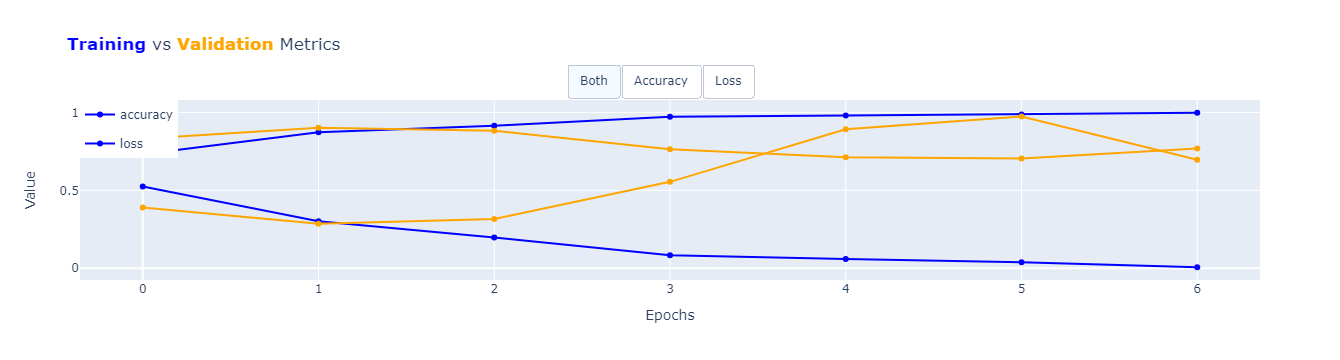

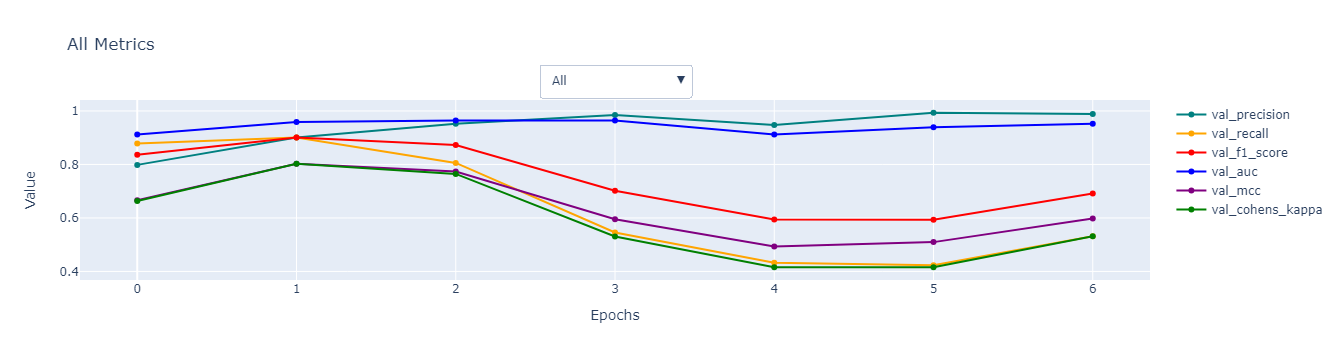

Validation Accuracy       AUC  Precision    Recall  F1 Score       MCC  \
cnn             0.901163  0.959056   0.900585  0.900585  0.900585  0.802319   

     Cohen's Kappa  
cnn       0.802319

In [16]:
metric_train_vs_val(hist_cnn)
other_metrics(hist_cnn)
model_performance('models/cnn')

# LSTM

A Bidirectional Long Short-Term Memory (BiLSTM) can be useful for image classification tasks by capturing spatial hierarchies in an image. Traditional LSTMs process data sequentially, which can be a limitation when dealing with images where spatial information in all directions is important. BiLSTMs, on the other hand, process data in both forward and backward directions. This allows them to capture information from both past (preceding pixels) and future (following pixels) at any point in the sequence. When applied to image classification, this means that the BiLSTM can consider the full context of each pixel in the image, potentially leading to more accurate classification results. 


## Build Model

In [17]:
# Flatten your images into sequences
data2 = data.map(lambda x, y: (tensorflow.reshape(x, (-1, 256, 256*3)), y))  # Reshape to (batch_size, timesteps, features)

model_lstm = tensorflow.keras.models.Sequential(name="BiLSTM")
model_lstm.add(tensorflow.keras.layers.Bidirectional(tensorflow.keras.layers.LSTM(128, return_sequences=True)))  # Input shape is inferred from the input data
model_lstm.add(tensorflow.keras.layers.Bidirectional(tensorflow.keras.layers.LSTM(64, return_sequences=True)))
model_lstm.add(tensorflow.keras.layers.Bidirectional(tensorflow.keras.layers.LSTM(32)))
model_lstm.add(tensorflow.keras.layers.Dense(16, activation='relu'))
model_lstm.add(tensorflow.keras.layers.Dense(8, activation='relu'))
model_lstm.add(tensorflow.keras.layers.Dense(1, activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)

## Train Model

In [18]:
hist_lstm = fit_model(model_lstm,'lstm',data2)

Epoch 1/100000
153/153 [==============================] - ETA: 0s - loss: 0.5692 - accuracy: 0.7075 - auc: 0.7924 - precision: 0.7322 - recall: 0.7001 - f1_score: 0.7158 - mcc: 0.4425 - cohens_kappa: 0.4421
Epoch 1: val_accuracy improved from -inf to 0.51163, saving model to models/lstm\lstm.h5

Available RAM : 3.12 GB

153/153 [==============================] - 37s 191ms/step - loss: 0.5692 - accuracy: 0.7075 - auc: 0.7924 - precision: 0.7322 - recall: 0.7001 - f1_score: 0.7158 - mcc: 0.4425 - cohens_kappa: 0.4421 - val_loss: 0.7196 - val_accuracy: 0.5116 - val_auc: 0.5377 - val_precision: 0.5024 - val_recall: 0.3116 - val_f1_score: 0.3846 - val_mcc: 0.0166 - val_cohens_kappa: 0.0154
Epoch 2/100000
153/153 [==============================] - ETA: 0s - loss: 0.5205 - accuracy: 0.7496 - auc: 0.8158 - precision: 0.7213 - recall: 0.8222 - f1_score: 0.7684 - mcc: 0.5034 - cohens_kappa: 0.4984
Epoch 2: val_accuracy improved from 0.51163 to 0.53343, saving model to models/lstm\lstm.h5

Availa

In [19]:
model_lstm.summary()

Model: "BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256, 256)         918528    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256, 128)         164352    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                            

## View Metrics

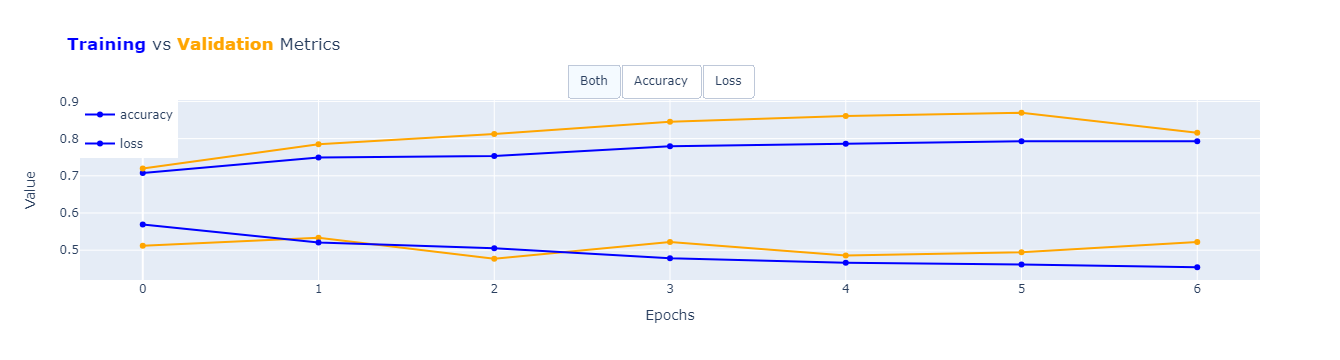

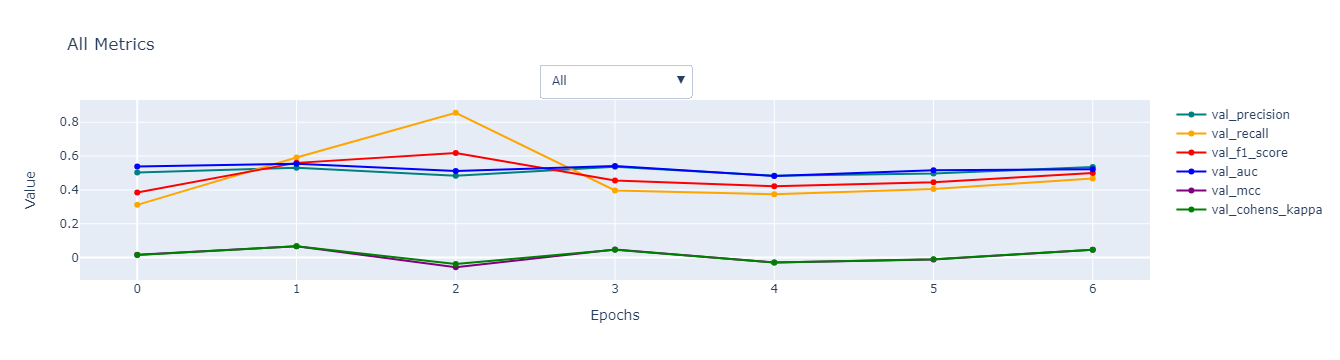

Validation Accuracy       AUC  Precision    Recall  F1 Score       MCC  \
lstm              0.53343  0.554481    0.53125  0.591304  0.559671  0.066977   

      Cohen's Kappa  
lstm       0.066545

In [20]:
metric_train_vs_val(hist_lstm)
other_metrics(hist_lstm)
model_performance('models/lstm')

# GRU

The GRU is a type of RNN architecture that uses gating mechanisms to control and manage the flow of information between cells in the network. These gates decide which information should be passed on to the next cell. This helps to mitigate the vanishing gradient problem which is a common issue in traditional RNNs, making it difficult for the model to learn and understand long-term dependencies.

In a BiGRU, two separate GRUs are run on the input sequence: one in a forward direction and one in a backward direction. The outputs of these two GRUs are then concatenated and passed on to the next layer of the network. This bidirectional processing allows the model to capture both past and future context, making it particularly effective for tasks that require understanding of the full context of the input data.

A Bidirectional Gated Recurrent Unit (BiGRU) can be beneficial for image classification tasks by effectively capturing spatial dependencies in an image. When applied to image classification, the BiGRU can consider the full context of each pixel in the image, potentially leading to more accurate classification results. 


## Build Model

In [21]:
model_gru = tensorflow.keras.models.Sequential(name="BiGRU")
model_gru.add(tensorflow.keras.layers.Bidirectional(tensorflow.keras.layers.GRU(128, return_sequences=True)))  # Input shape is inferred from the input data
model_gru.add(tensorflow.keras.layers.Bidirectional(tensorflow.keras.layers.GRU(64, return_sequences=True)))
model_gru.add(tensorflow.keras.layers.Bidirectional(tensorflow.keras.layers.GRU(32)))
model_gru.add(tensorflow.keras.layers.Dense(16, activation='relu'))
model_gru.add(tensorflow.keras.layers.Dense(8, activation='relu'))
model_gru.add(tensorflow.keras.layers.Dense(1, activation='sigmoid'))

model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)

## Train Model

In [22]:
hist_gru = fit_model(model_gru,'GRU',data2)

Epoch 1/100000
153/153 [==============================] - ETA: 0s - loss: 0.6322 - accuracy: 0.6495 - auc: 0.6529 - precision: 0.6133 - recall: 0.6832 - f1_score: 0.6464 - mcc: 0.2434 - cohens_kappa: 0.2417
Epoch 1: val_accuracy improved from -inf to 0.54070, saving model to models/GRU\GRU.h5

Available RAM : 3.05 GB

153/153 [==============================] - 37s 192ms/step - loss: 0.6322 - accuracy: 0.6495 - auc: 0.6529 - precision: 0.6133 - recall: 0.6832 - f1_score: 0.6464 - mcc: 0.2434 - cohens_kappa: 0.2417 - val_loss: 0.7053 - val_accuracy: 0.5407 - val_auc: 0.5484 - val_precision: 0.5287 - val_recall: 0.3909 - val_f1_score: 0.4495 - val_mcc: 0.0728 - val_cohens_kappa: 0.0704
Epoch 2/100000
153/153 [==============================] - ETA: 0s - loss: 0.5160 - accuracy: 0.7553 - auc: 0.8231 - precision: 0.7288 - recall: 0.8202 - f1_score: 0.7718 - mcc: 0.5142 - cohens_kappa: 0.5100
Epoch 2: val_accuracy did not improve from 0.54070

Available RAM : 3.51 GB

153/153 [===============

In [23]:
model_gru.summary()

Model: "BiGRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 256, 256)         689664    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 256, 128)         123648    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               31104     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 16)                1040      
                                                                 
 dense_6 (Dense)             (None, 8)                 136       
                                                             

## View Metrics

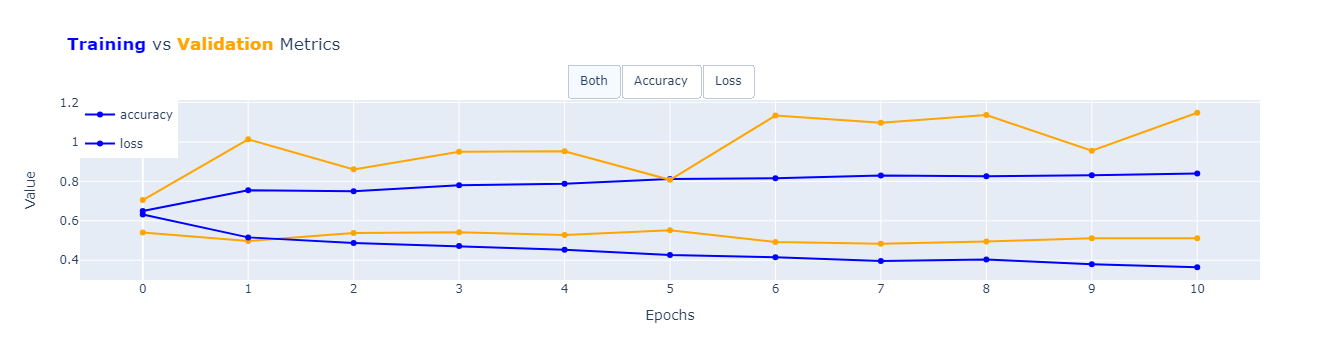

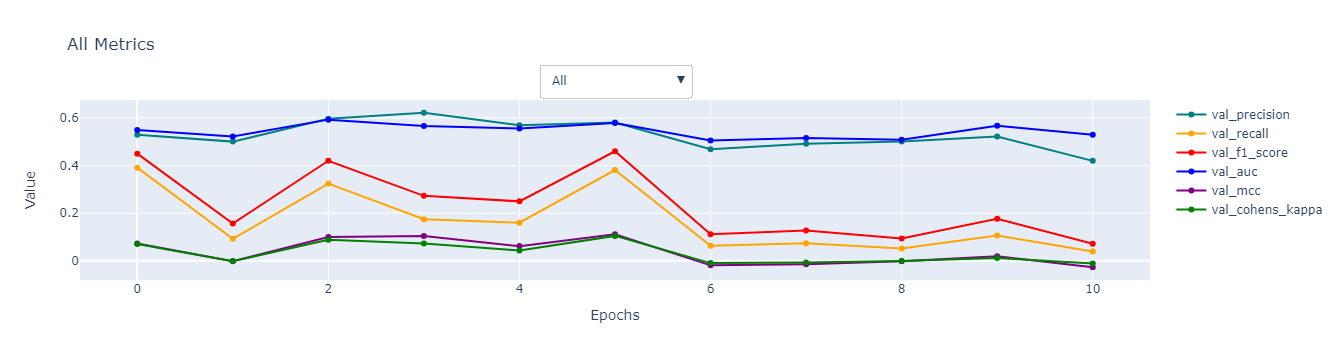

Validation Accuracy       AUC  Precision    Recall  F1 Score       MCC  \
gru             0.552326  0.578383   0.579646  0.380814  0.459649  0.111411   

     Cohen's Kappa  
gru       0.104651

In [24]:
metric_train_vs_val(hist_gru)
other_metrics(hist_gru)
model_performance('models/gru')

# Keras Applications ' Models

Keras Applications are deep learning models that are made available alongside pre-trained weights. These models can be used for prediction, feature extraction, and fine-tuning. (https://keras.io/api/applications/)

In [25]:
def model_builder(name,n='all'):
    
    base_model = eval(f"tensorflow.keras.applications.{name}(weights='imagenet', include_top=False, input_shape=(256, 256, 3))")
    
    # Freeze the layers in the base model
    n = len(base_model.layers)
    if (n!='all') : n = int(n)
        
    for layer in base_model.layers[:n]: layer.trainable = False
    for layer in base_model.layers[n:]: layer.trainable = True
    
    model =  tensorflow.keras.models.Sequential(name=name)
    model.add(base_model)
    model.add(tensorflow.keras.layers.Flatten())
    model.add(tensorflow.keras.layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    return model

# ResNet50

ResNet50 is a pre-trained model that has been trained on a million images from the ImageNet database[x]. The architecture of ResNet50 includes 48 Convolution layers along with 1 MaxPool and 1 Average Pool layer. A key feature of ResNet50 is the use of “skip connections” that allow the gradient to be directly backpropagated to earlier layers, making it easier to train deeper models.

The use of ResNet50 for image classification comes with several advantages. ResNet50 is a good choice for transfer learning where the learned features of one model are leveraged on a different related task. The depth of the network allows it to learn more complex features at higher abstraction levels and the residual blocks in ResNet help mitigate the vanishing gradient problem.

## Build Model

In [26]:
model_ResNet50 = model_builder('ResNet50',n='all')
print(model_ResNet50.summary())

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_8 (Dense)             (None, 1)                 131073    
                                                                 
Total params: 23,718,785
Trainable params: 131,073
Non-trainable params: 23,587,712
_________________________________________________________________
None


## Train Model

In [27]:
hist_rn50 = fit_model(model_ResNet50,'ResNet50',data)

Epoch 1/100000
153/153 [==============================] - ETA: 0s - loss: 0.5398 - accuracy: 0.7872 - auc: 0.8168 - precision: 0.7727 - recall: 0.6420 - f1_score: 0.7013 - mcc: 0.4600 - cohens_kappa: 0.4534
Epoch 1: val_accuracy improved from -inf to 0.79506, saving model to models/ResNet50\ResNet50.h5

Available RAM : 3.20 GB

153/153 [==============================] - 30s 173ms/step - loss: 0.5398 - accuracy: 0.7872 - auc: 0.8168 - precision: 0.7727 - recall: 0.6420 - f1_score: 0.7013 - mcc: 0.4600 - cohens_kappa: 0.4534 - val_loss: 0.5064 - val_accuracy: 0.7951 - val_auc: 0.9655 - val_precision: 0.9810 - val_recall: 0.6006 - val_f1_score: 0.7450 - val_mcc: 0.6395 - val_cohens_kappa: 0.5897
Epoch 2/100000
153/153 [==============================] - ETA: 0s - loss: 0.3633 - accuracy: 0.8603 - auc: 0.9340 - precision: 0.8511 - recall: 0.8785 - f1_score: 0.8646 - mcc: 0.7208 - cohens_kappa: 0.7204
Epoch 2: val_accuracy improved from 0.79506 to 0.86047, saving model to models/ResNet50\Res

## View Metrics

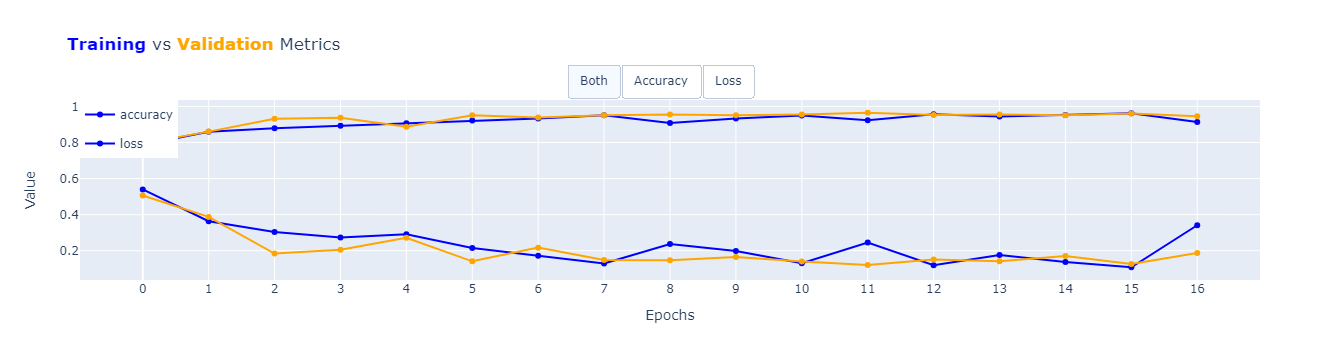

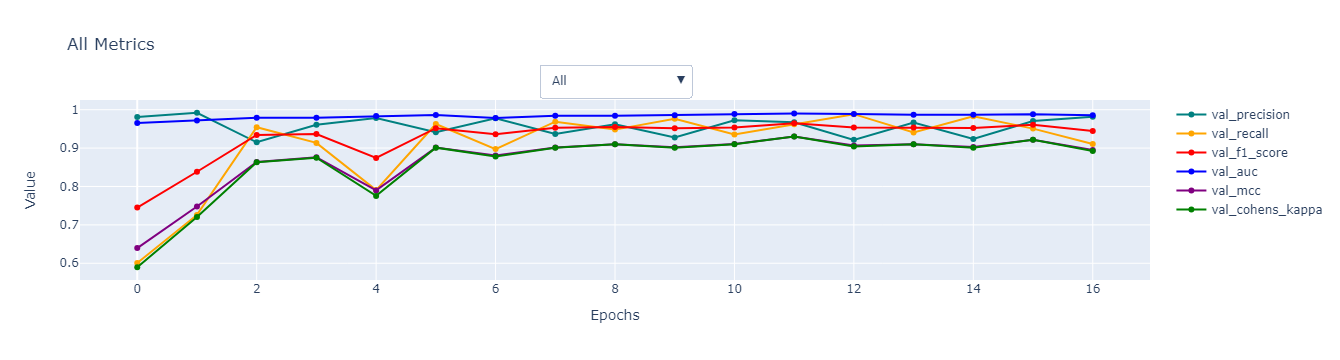

Validation Accuracy       AUC  Precision    Recall  F1 Score  \
ResNet50             0.965116  0.990192   0.967456  0.961765  0.964602   

               MCC  Cohen's Kappa  
ResNet50  0.930234       0.930218

In [28]:
metric_train_vs_val(hist_rn50)
other_metrics(hist_rn50)
model_performance('models/ResNet50')

# DenseNet121

This is a variant of Convolutional Neural Networks (CNNs). DenseNet121 is a pre-trained model that has been trained on over a million images from the ImageNet database. 

The architecture of DenseNet121 includes densely connected layers. A key feature of DenseNet121 is that each layer obtains additional inputs from all preceding layers and passes on its own feature-maps to all subsequent layers.

The depth of the network allows it to learn more complex features at higher abstraction levels. The dense connections help mitigate the vanishing gradient problem which is a common issue in traditional deep neural networks as it  makes it difficult for the model to learn long-term dependencies


## Build Model

In [29]:
# Load the DenseNet121 model with pre-trained weights
model_DenseNet121 = model_builder('DenseNet121',n=1)
print(model_DenseNet121.summary())

Model: "DenseNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 flatten_2 (Flatten)         (None, 65536)             0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65537     
                                                                 
Total params: 7,103,041
Trainable params: 65,537
Non-trainable params: 7,037,504
_________________________________________________________________
None


## Train Model

In [30]:
hist_dn121 = fit_model(model_DenseNet121,'DenseNet121',data)

Epoch 1/100000
153/153 [==============================] - ETA: 0s - loss: 0.1829 - accuracy: 0.9636 - auc: 0.9860 - precision: 0.9655 - recall: 0.9545 - f1_score: 0.9600 - mcc: 0.9197 - cohens_kappa: 0.9196
Epoch 1: val_accuracy improved from -inf to 0.98401, saving model to models/DenseNet121\DenseNet121.h5

Available RAM : 3.02 GB

153/153 [==============================] - 46s 264ms/step - loss: 0.1829 - accuracy: 0.9636 - auc: 0.9860 - precision: 0.9655 - recall: 0.9545 - f1_score: 0.9600 - mcc: 0.9197 - cohens_kappa: 0.9196 - val_loss: 0.0533 - val_accuracy: 0.9840 - val_auc: 0.9970 - val_precision: 0.9712 - val_recall: 0.9970 - val_f1_score: 0.9839 - val_mcc: 0.9684 - val_cohens_kappa: 0.9680
Epoch 2/100000
153/153 [==============================] - ETA: 0s - loss: 0.0301 - accuracy: 0.9931 - auc: 0.9990 - precision: 0.9935 - recall: 0.9927 - f1_score: 0.9931 - mcc: 0.9861 - cohens_kappa: 0.9861
Epoch 2: val_accuracy improved from 0.98401 to 0.99564, saving model to models/DenseN

## View Metrics

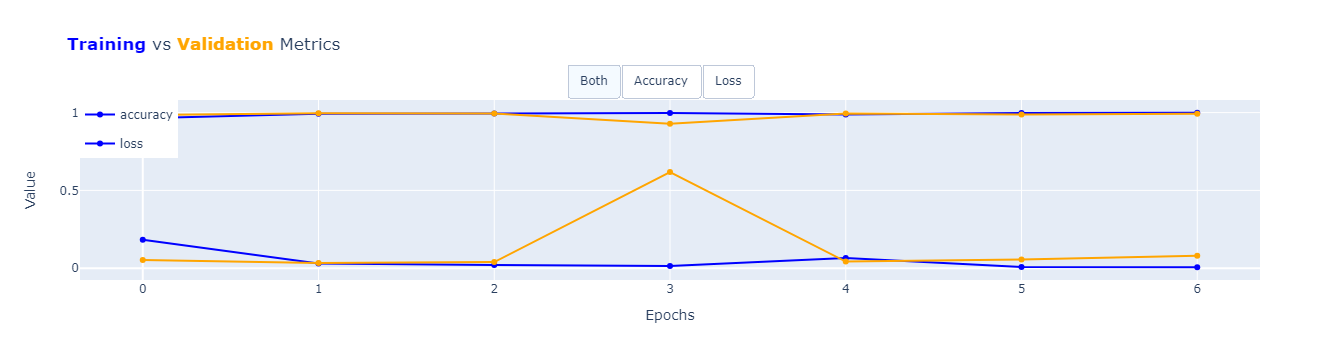

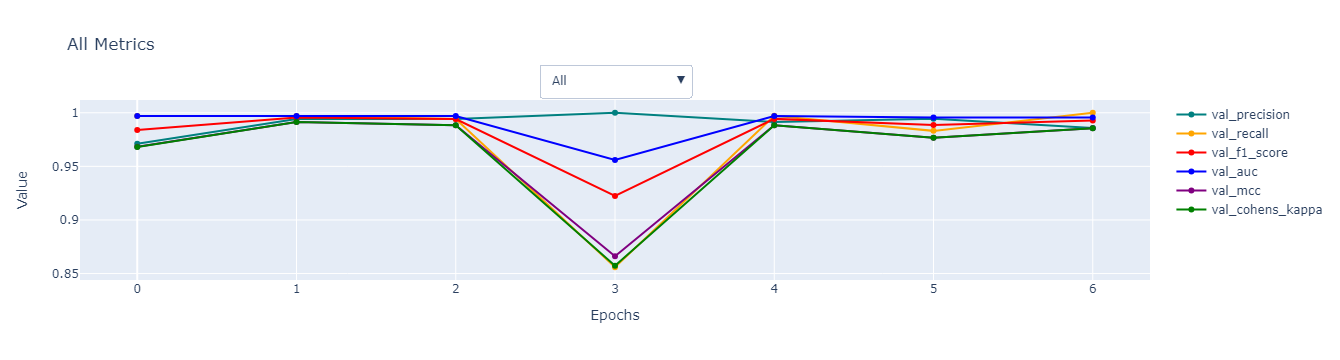

Validation Accuracy       AUC  Precision    Recall  F1 Score  \
DenseNet121              0.99564  0.997038   0.994169  0.997076   0.99562   

                  MCC  Cohen's Kappa  
DenseNet121  0.991283       0.991279

In [31]:
metric_train_vs_val(hist_dn121)
other_metrics(hist_dn121)
model_performance('models/DenseNet121')

# MobileNetV2

MobileNetV2 is a variant of Convolutional Neural Networks (CNNs). MobileNetV2 is a pre-trained model that has been trained on over a million images from the ImageNet database. The architecture of MobileNetV2 includes densely connected layers.

The learned universal features from a large dataset (ImageNet) can be generalized to other tasks. This makes MobileNetV2 a good choice for transfer learning where the learned features of one model are leveraged on a different related task. MobileNetV2 models are faster due to the reduced model size and complexity.


## Build Model

In [32]:
# Load the MobileNetV2 model with pre-trained weights
model_MobileNetV2 = model_builder('MobileNetV2',n='all')
print(model_MobileNetV2.summary())

Model: "MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_3 (Flatten)         (None, 81920)             0         
                                                                 
 dense_10 (Dense)            (None, 1)                 81921     
                                                                 
Total params: 2,339,905
Trainable params: 81,921
Non-trainable params: 2,257,984
_________________________________________________________________
None


## Train Model

In [33]:
hist_mnv2 = fit_model(model_MobileNetV2,'MobileNetV2',data)

Epoch 1/100000
153/153 [==============================] - ETA: 0s - loss: 0.2153 - accuracy: 0.9600 - auc: 0.9848 - precision: 0.9672 - recall: 0.9678 - f1_score: 0.9675 - mcc: 0.9343 - cohens_kappa: 0.9343
Epoch 1: val_accuracy improved from -inf to 0.98401, saving model to models/MobileNetV2\MobileNetV2.h5

Available RAM : 2.93 GB

153/153 [==============================] - 19s 104ms/step - loss: 0.2153 - accuracy: 0.9600 - auc: 0.9848 - precision: 0.9672 - recall: 0.9678 - f1_score: 0.9675 - mcc: 0.9343 - cohens_kappa: 0.9343 - val_loss: 0.1003 - val_accuracy: 0.9840 - val_auc: 0.9937 - val_precision: 0.9884 - val_recall: 0.9798 - val_f1_score: 0.9841 - val_mcc: 0.9681 - val_cohens_kappa: 0.9680
Epoch 2/100000
153/153 [==============================] - ETA: 0s - loss: 0.0494 - accuracy: 0.9902 - auc: 0.9970 - precision: 0.9919 - recall: 0.9886 - f1_score: 0.9903 - mcc: 0.9804 - cohens_kappa: 0.9804
Epoch 2: val_accuracy did not improve from 0.98401

Available RAM : 2.91 GB

153/153 

## View Metrics

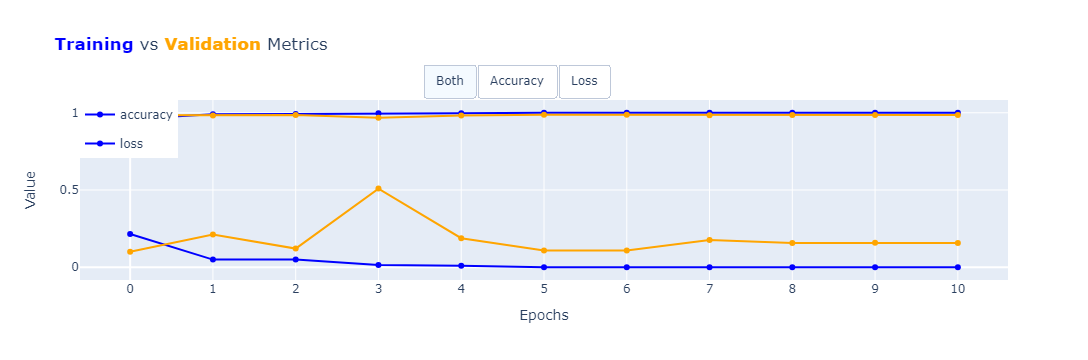

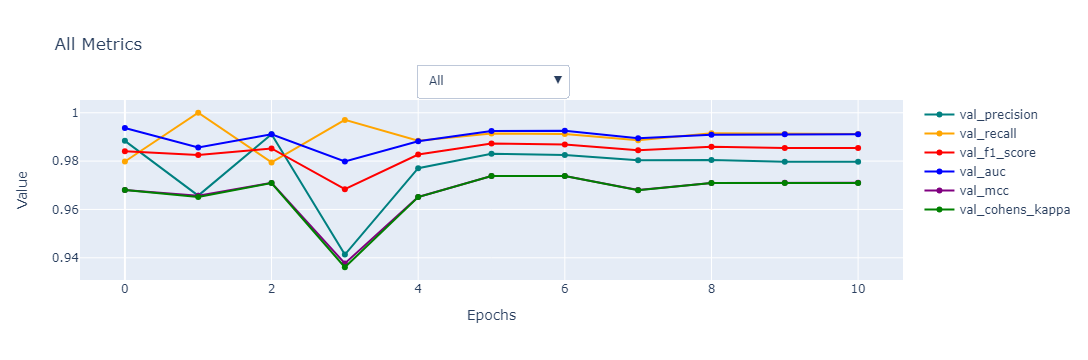

Validation Accuracy     AUC  Precision    Recall  F1 Score  \
MobileNetV2             0.986919  0.9924   0.983051  0.991453  0.987234   

                  MCC  Cohen's Kappa  
MobileNetV2  0.973859       0.973822

In [34]:
metric_train_vs_val(hist_mnv2)
other_metrics(hist_mnv2)
model_performance('models/MobileNetV2')

# InceptionV3
 InceptionV3 is a model that uses a lot of concatenated convolutions to extract features from different scales and then uses 1x1 convolutions to reduce the dimensionality of the feature maps. This allows it to have a large receptive field while keeping the computational cost low.

## Build Model

In [35]:
# Load the InceptionV3 model with pre-trained weights
model_InceptionV3 = model_builder('InceptionV3',n='all')
print(model_InceptionV3.summary())

Model: "InceptionV3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_4 (Flatten)         (None, 73728)             0         
                                                                 
 dense_11 (Dense)            (None, 1)                 73729     
                                                                 
Total params: 21,876,513
Trainable params: 73,729
Non-trainable params: 21,802,784
_________________________________________________________________
None


## Train Model

In [36]:
hist_iv3 = fit_model(model_InceptionV3,'InceptionV3',data)

Epoch 1/100000
153/153 [==============================] - ETA: 0s - loss: 0.4346 - accuracy: 0.9371 - auc: 0.9676 - precision: 0.9492 - recall: 0.9468 - f1_score: 0.9480 - mcc: 0.8954 - cohens_kappa: 0.8954
Epoch 1: val_accuracy improved from -inf to 0.98692, saving model to models/InceptionV3\InceptionV3.h5

Available RAM : 2.66 GB

153/153 [==============================] - 32s 183ms/step - loss: 0.4346 - accuracy: 0.9371 - auc: 0.9676 - precision: 0.9492 - recall: 0.9468 - f1_score: 0.9480 - mcc: 0.8954 - cohens_kappa: 0.8954 - val_loss: 0.0782 - val_accuracy: 0.9869 - val_auc: 0.9954 - val_precision: 0.9942 - val_recall: 0.9800 - val_f1_score: 0.9871 - val_mcc: 0.9739 - val_cohens_kappa: 0.9738
Epoch 2/100000
153/153 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9910 - auc: 0.9978 - precision: 0.9919 - recall: 0.9903 - f1_score: 0.9911 - mcc: 0.9820 - cohens_kappa: 0.9820
Epoch 2: val_accuracy improved from 0.98692 to 0.99128, saving model to models/Incept

## View Metrics

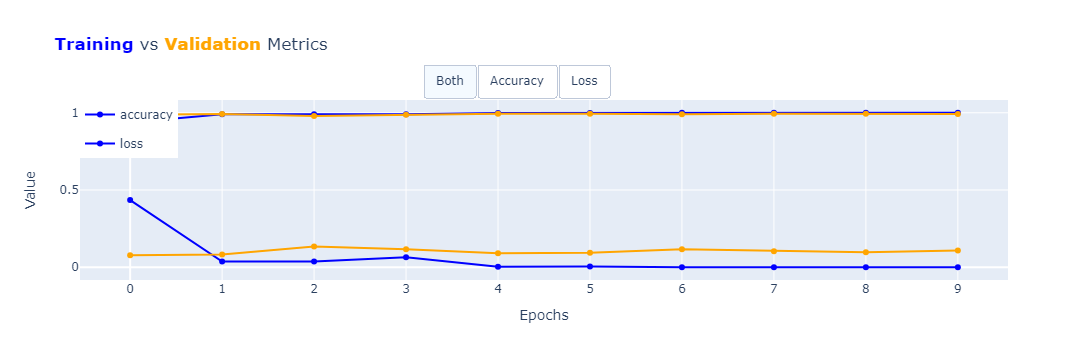

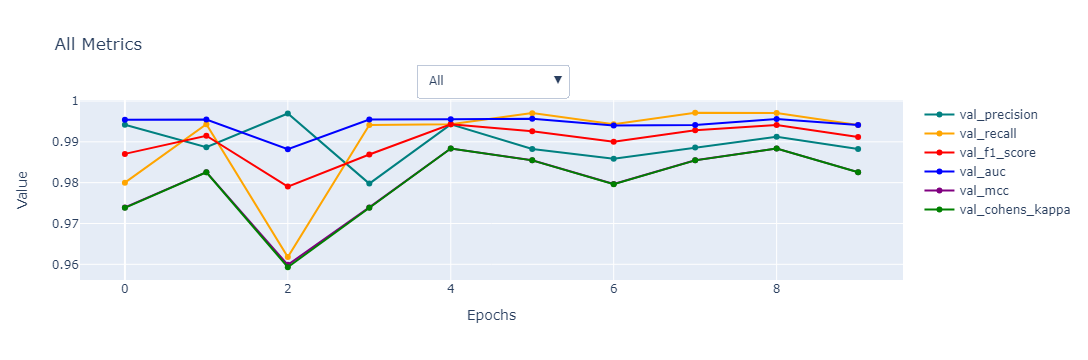

Validation Accuracy       AUC  Precision    Recall  F1 Score  \
InceptionV3             0.994186  0.995537   0.994286  0.994286  0.994286   

                  MCC  Cohen's Kappa  
InceptionV3  0.988369       0.988369

In [37]:
metric_train_vs_val(hist_iv3)
other_metrics(hist_iv3)
model_performance('models/InceptionV3')

# Xception
Xception is an extension of the Inception architecture which replaces the standard Inception modules with depthwise separable convolutions.

## Build Model

In [38]:
# Load the Xception model with pre-trained weights
model_Xception = model_builder('Xception',n='all')
print(model_Xception.summary())

Model: "Xception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten_5 (Flatten)         (None, 131072)            0         
                                                                 
 dense_12 (Dense)            (None, 1)                 131073    
                                                                 
Total params: 20,992,553
Trainable params: 131,073
Non-trainable params: 20,861,480
_________________________________________________________________
None


## Train Model

In [39]:
hist_X = fit_model(model_Xception,'Xception',data)

Epoch 1/100000
153/153 [==============================] - ETA: 0s - loss: 0.2495 - accuracy: 0.9457 - auc: 0.9822 - precision: 0.9538 - recall: 0.9581 - f1_score: 0.9559 - mcc: 0.9114 - cohens_kappa: 0.9113
Epoch 1: val_accuracy improved from -inf to 0.97529, saving model to models/Xception\Xception.h5

Available RAM : 2.46 GB

153/153 [==============================] - 42s 254ms/step - loss: 0.2495 - accuracy: 0.9457 - auc: 0.9822 - precision: 0.9538 - recall: 0.9581 - f1_score: 0.9559 - mcc: 0.9114 - cohens_kappa: 0.9113 - val_loss: 0.1332 - val_accuracy: 0.9753 - val_auc: 0.9878 - val_precision: 0.9970 - val_recall: 0.9543 - val_f1_score: 0.9752 - val_mcc: 0.9515 - val_cohens_kappa: 0.9506
Epoch 2/100000
153/153 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9833 - auc: 0.9938 - precision: 0.9829 - recall: 0.9837 - f1_score: 0.9833 - mcc: 0.9665 - cohens_kappa: 0.9665
Epoch 2: val_accuracy improved from 0.97529 to 0.98692, saving model to models/Xception\Xce

## View Metrics

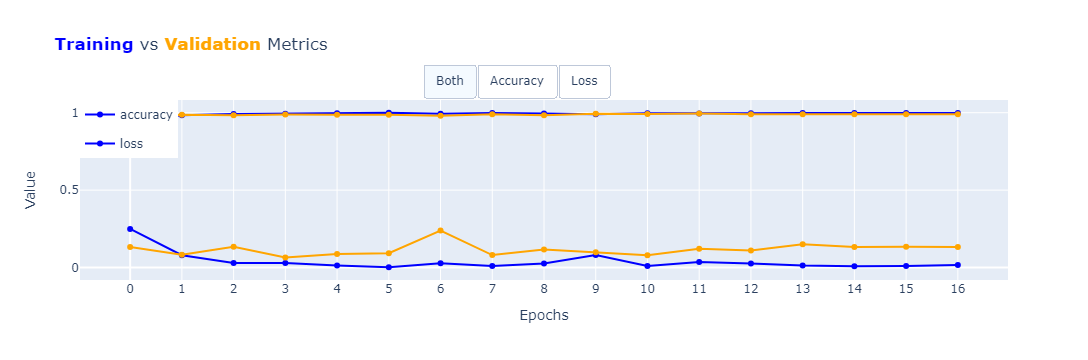

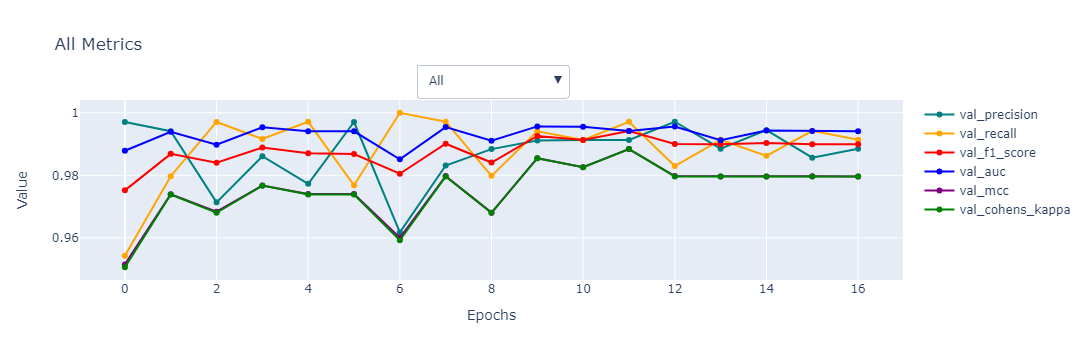

Validation Accuracy       AUC  Precision    Recall  F1 Score  \
Xception             0.994186  0.994182   0.991304  0.997085  0.994186   

               MCC  Cohen's Kappa  
Xception  0.988389       0.988372

In [40]:
metric_train_vs_val(hist_X)
other_metrics(hist_X)
model_performance('models/Xception')

# NASNetMobile
NASNet refers to Neural Architecture Search Network, a model that was developed by Google’s AutoML project. The architecture of NASNet models is learned by a reinforcement learning algorithm.

## Build Model

In [41]:
# Load the NASNetMobile model with pre-trained weights
model_NASNetMobile = model_builder('NASNetMobile',n='all')
print(model_NASNetMobile.summary())

Model: "NASNetMobile"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 8, 8, 1056)        4269716   
                                                                 
 flatten_6 (Flatten)         (None, 67584)             0         
                                                                 
 dense_13 (Dense)            (None, 1)                 67585     
                                                                 
Total params: 4,337,301
Trainable params: 67,585
Non-trainable params: 4,269,716
_________________________________________________________________
None


## Train Model

In [42]:
hist_nnm = fit_model(model_NASNetMobile,'NASNetMobile',data)

Epoch 1/100000
153/153 [==============================] - ETA: 0s - loss: 0.4138 - accuracy: 0.9138 - auc: 0.9677 - precision: 0.9308 - recall: 0.9320 - f1_score: 0.9314 - mcc: 0.8609 - cohens_kappa: 0.8609
Epoch 1: val_accuracy improved from -inf to 0.95494, saving model to models/NASNetMobile\NASNetMobile.h5

Available RAM : 2.33 GB

153/153 [==============================] - 36s 171ms/step - loss: 0.4138 - accuracy: 0.9138 - auc: 0.9677 - precision: 0.9308 - recall: 0.9320 - f1_score: 0.9314 - mcc: 0.8609 - cohens_kappa: 0.8609 - val_loss: 0.1746 - val_accuracy: 0.9549 - val_auc: 0.9885 - val_precision: 0.9588 - val_recall: 0.9504 - val_f1_score: 0.9546 - val_mcc: 0.9099 - val_cohens_kappa: 0.9099
Epoch 2/100000
153/153 [==============================] - ETA: 0s - loss: 0.0801 - accuracy: 0.9747 - auc: 0.9953 - precision: 0.9741 - recall: 0.9757 - f1_score: 0.9749 - mcc: 0.9493 - cohens_kappa: 0.9493
Epoch 2: val_accuracy improved from 0.95494 to 0.95785, saving model to models/NASN

## View Metrics

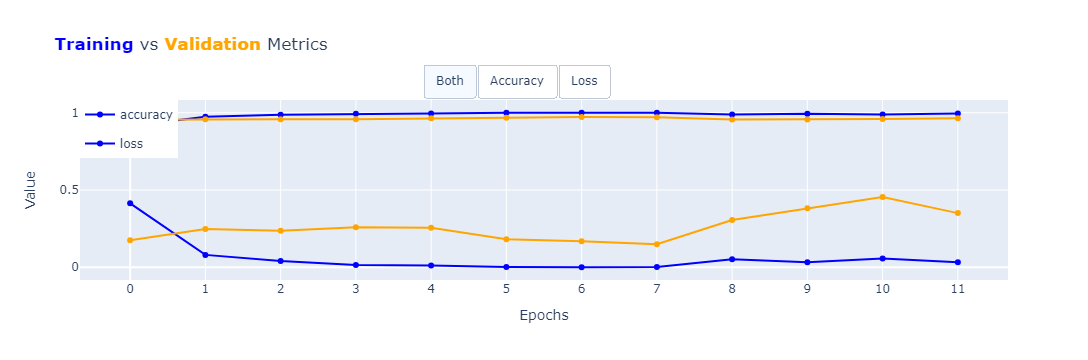

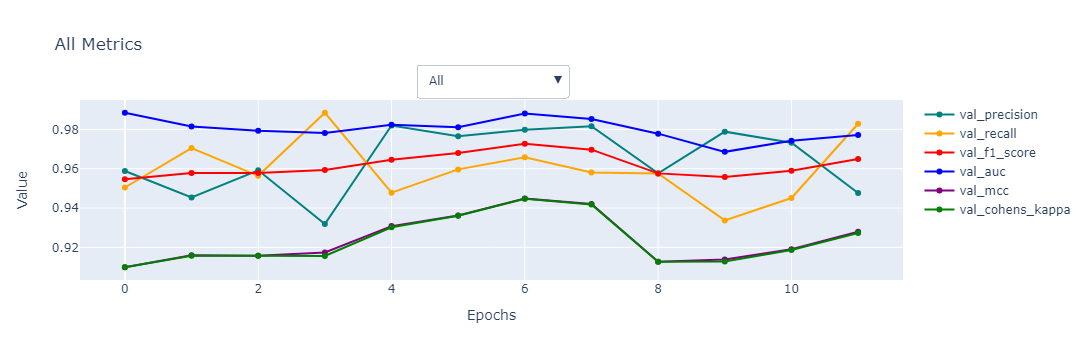

Validation Accuracy       AUC  Precision    Recall  F1 Score  \
NASNetMobile             0.972384  0.988033   0.979769  0.965812   0.97274   

                   MCC  Cohen's Kappa  
NASNetMobile  0.944861       0.944761

In [43]:
metric_train_vs_val(hist_nnm)
other_metrics(hist_nnm)
model_performance('models/NASNetMobile')

# Evaluate Against Test Data

In [44]:
import gc
gc.collect()

train_size = int(len(data)*0.7)
val_size = int(len(data)*0.20)
test_size = int(len(data)*.10)
test_ds = data.skip(train_size+val_size).take(test_size)

## Load models and Predict Against Test Data

In [45]:
parent_folder_path = 'models'
models = {}
metrics = ['accuracy',
           tensorflow.keras.metrics.AUC(),
           tensorflow.keras.metrics.Precision(),
           tensorflow.keras.metrics.Recall(),
           F1Score(),
           MCC(),
           CohensKappa()
          ]

for item in os.listdir(parent_folder_path):
    item_path = os.path.join(parent_folder_path, item)
    if os.path.isdir(item_path):
        for file in os.listdir(item_path):
            if file.endswith(".h5"):
                file_path = os.path.join(item_path, file)
                print(f'\nEvaluating model {file} ....')
                model = tensorflow.keras.models.load_model(
                    file_path,
                    custom_objects={'auc':tensorflow.keras.metrics.AUC(),
                                    'precision':tensorflow.keras.metrics.Precision(),
                                    'recall':tensorflow.keras.metrics.Recall(),
                                    'f1-score':  F1Score(),
                                    'cohens_kappa': CohensKappa()
                                    },
                    compile=False
                )
                model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
                if file == 'LSTM.h5' or file == 'GRU.h5':
                    _ = test_ds
                    re_shaped_test = _.map(lambda x, y: (tensorflow.reshape(x, (-1, 256, 256*3)), y))
                    test_results = model.evaluate(re_shaped_test)
                    models[item] = test_results
                else :
                    test_results = model.evaluate(test_ds)
                    models[item] = test_results


Evaluating model cnn.h5 ....
21/21 [==============================] - 9s 21ms/step - loss: 0.2591 - accuracy: 0.9167 - auc_1: 0.9579 - precision_2: 0.8909 - recall_2: 0.9363 - f1_score: 0.9130 - mcc: 0.8341 - cohens_kappa: 0.8331

Evaluating model DenseNet121.h5 ....
21/21 [==============================] - 13s 157ms/step - loss: 2.1171e-04 - accuracy: 1.0000 - auc_1: 0.9895 - precision_2: 0.9455 - recall_2: 0.9689 - f1_score: 0.9571 - mcc: 0.9169 - cohens_kappa: 0.9166

Evaluating model GRU.h5 ....
21/21 [==============================] - 12s 54ms/step - loss: 0.4999 - accuracy: 0.7649 - auc_1: 0.9672 - precision_2: 0.8369 - recall_2: 0.9692 - f1_score: 0.8982 - mcc: 0.7978 - cohens_kappa: 0.7885

Evaluating model InceptionV3.h5 ....
21/21 [==============================] - 12s 99ms/step - loss: 0.1155 - accuracy: 0.9940 - auc_1: 0.9798 - precision_2: 0.8721 - recall_2: 0.9754 - f1_score: 0.9208 - mcc: 0.8438 - cohens_kappa: 0.8382

Evaluating model LSTM.h5 ....
21/21 [==============

In [46]:
import pandas as pd
pd.set_option('display.max_colwidth', 100)

def display_model_metrics(models):
    metrics_names = ['loss', 'accuracy', 'auc', 'precision', 'recall', 'f1_score', 'mcc', 'cohens_kappa']
    data_list = []
    
    for model_name, metrics_values in models.items():
        data = {'model_name': model_name}
        data.update(dict(zip(metrics_names, metrics_values)))
        data_list.append(data)
    
    df = pd.DataFrame(data_list)
    df.set_index('model_name', inplace=True)
    
    return df

df = display_model_metrics(models)
df

loss  accuracy       auc  precision    recall  f1_score  \
model_name                                                                  
cnn           0.259052  0.916667  0.957940   0.890909  0.936306  0.913043   
DenseNet121   0.000212  1.000000  0.989494   0.945455  0.968944  0.957055   
GRU           0.499921  0.764881  0.967203   0.836879  0.969199  0.898192   
InceptionV3   0.115494  0.994048  0.979809   0.872077  0.975385  0.920842   
LSTM          0.512735  0.744048  0.961598   0.832613  0.950678  0.887738   
MobileNetV2   0.055826  0.994048  0.971781   0.856486  0.957819  0.904323   
NASNetMobile  0.277760  0.952381  0.973478   0.869427  0.957055  0.911139   
ResNet50      0.158362  0.958333  0.975916   0.879859  0.956221  0.916452   
Xception      0.300793  0.976190  0.978046   0.889308  0.959946  0.923278   

                   mcc  cohens_kappa  
model_name                            
cnn           0.834087      0.833138  
DenseNet121   0.916865      0.916605  
GRU           0.797838      0.788548  
InceptionV3   0.843759      0.838231  
LSTM          0.775929      0.768675  
MobileNetV2   0.810371      0.805109  
NASNetMobile  0.823173      0.819243  
ResNet50      0.834324      0.831380  
Xception      0.847317      0.844783

# Comparisons of Models

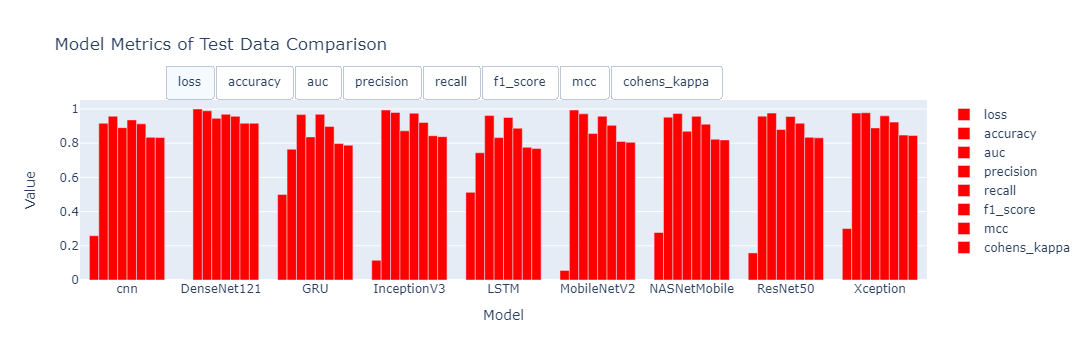

In [47]:
import plotly.graph_objects as go

def plot_metrics(df):
    # Create a subplot for each metric
    fig = go.Figure()
    
    # Loop over the metrics in the DataFrame
    for metric in df.columns:
        fig.add_trace(go.Bar(x=df.index, y=df[metric], name=metric, marker_color='red'))
    
    # Create buttons for each metric
    buttons = []
    for i, metric in enumerate(df.columns):
        visibility = [i == j for j in range(len(df.columns))]
        button = dict(label=metric,
                      method='update',
                      args=[{'visible': visibility},
                            {'title': f'Model Metrics of Test Data Comparison - {metric}',
                             'yaxis.title': 'Value'}])
        buttons.append(button)
    
    # Update layout
    fig.update_layout(
        updatemenus=[
            dict(
                type='buttons',
                direction="right",
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.1,
                xanchor="left",
                y=1.25,
                yanchor="top",
                buttons=buttons
            )
        ],
        barmode='group',
        xaxis_title='Model',
        yaxis_title='Value',
        title='Model Metrics of Test Data Comparison'
    )
    
    fig.show()

# Call the function with your DataFrame
plot_metrics(df)